In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import numpy as np
from IPython import display
from utils import *
pre_trained_model = tf.keras.models.load_model('saved_model/local_model')

c:\Users\Leong Teng Man\Documents\university\2022\sem 1\BSD3523 MACHINE LEARNING\Project\utils.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  digits = np.array(digits)


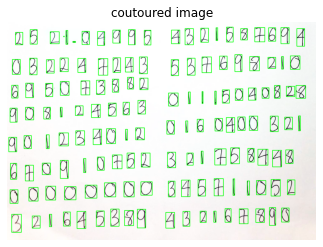

In [3]:
rel_dir = 'raw image'
filename = 'sca3.jpg'

img = cv2.imread(f'{rel_dir}/{filename}')
digits = crop_number(img.copy(), True)
digits = transform_cropped_digit(digits)

1/1 [==============================] - 0s 213ms/step


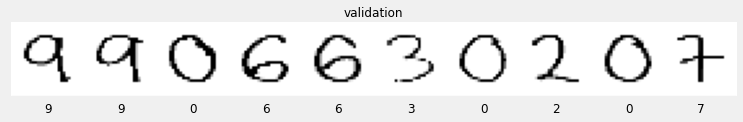

In [4]:
digits = digits[:10].reshape(-1, 28*28)
pred = pre_trained_model.predict(digits)
pred = [np.argmax(p) for p in pred]
pred = np.array(pred)
display_digits_alt_line(digits, pred, 'validation', pred.shape[0])

In [6]:
digits = crop_number(img.copy(), True)
digits = digits[:10]
digits, labels = manual_label(digits)
digits = transform_cropped_digit(digits, labels)

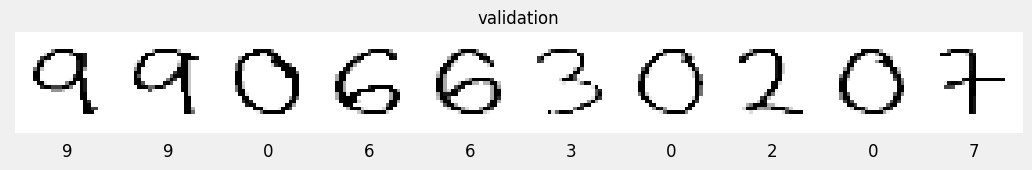

In [7]:
display_digits_line(digits, np.array(labels), pred, 'validation', len(labels))